In [2]:
!pip install vaderSentiment scipy datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00


In [3]:
# Load model directly
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
import pandas as pd
import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
import os
import scipy


# FinBERT
class FinBERT:
    """
    Class for FinBERT model that predicts sentiment of a text.
    """

    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

    def predict_return_all_labels(self, text: str):
      inputs = self.tokenizer(text, return_tensors="pt")
      with torch.no_grad():
        logits = self.model(**inputs).logits
        scores = {k: v for k, v in zip(self.model.config.id2label.values(), scipy.special.softmax(logits.numpy().squeeze()))}
      return scores

    def __init__(self, device: int = -1, return_one_label: bool = Fal) -> None:
        self.name = "finbert"
        self.pipe = pipeline("text-classification", model="ProsusAI/finbert", device=device) if return_one_label else self.predict_return_all_labels

    def pipeline_predict_sentiment(self, texts: str | list[str]) -> pd.DataFrame:
        """
        Predicts sentiment of a text or list of texts.
        # TODO: add option to return probabilities

        :param texts: str or list[str], text(s) to predict sentiment of
        """
        print("Predicting...")
        # return tqdm(self.pipe(texts))
        predictions = []
        for text in tqdm.tqdm(texts):
            tmp_prediction = self.pipe(text)
            # predictions += tmp_prediction - WORKS WHEN ONE LABEL IS RETURNED
            predictions.append(tmp_prediction)
        predictions = pd.json_normalize(predictions)
        predictions.rename(columns={'positive': 'finbert_positive', 'neutral': 'finbert_neutral', 'negative': 'finbert_negative'}, inplace=True)
        return predictions

        # BELOW WORKS WHEN ONE LABEL IS RETURNED
        # predictions = pd.json_normalize(predictions)
        # predictions.rename(columns={"label": "finbert_label", "score": "finbert_score"}, inplace=True)
        # return predictions

    def add_predictions_to_df(df: pd.DataFrame, predictions: pd.DataFrame) -> pd.DataFrame:
        """
        Adds predictions to a dataframe.

        :param df: pd.DataFrame, dataframe to add predictions to
        :param predictions: list, predictions to add to dataframe
        :return: pd.DataFrame, dataframe with predictions added
        """
        return pd.concat([df, predictions], axis=1)



# BartLargeMNLI
class BartLargeMNLI:
    """
    Class for BART model that predicts classes of a text. One can use own classes or use the default ones.
    """

    tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
    model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")
    def __init__(self):
        self.pipe = None

    def initialize_model(self, device: int = -1) -> None:
        """
        Initializes the model.

        :param device: int, -1 for CPU, 0 for GPU
        """
        self.pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", tokenizer="facebook/bart-large-mnli", device=device)

    def predict_classes(self, texts: str | list[str], classes: list[str], multi_label: bool = True) -> list:
        """
        Predicts classes of a text or list of texts.

        :param texts: str or list[str], text(s) to predict classes of
        :param classes: list[str], classes to predict
        :param multi_label: bool, whether to predict multiple classes or not
        :return: list, predictions
        """
        predictions = []
        for text in tqdm.tqdm(texts):
            predictions.append(self.pipe(text, classes, multi_label=multi_label))
        return predictions
        # return self.pipe(texts, classes, multi_label=multi_label)
        # return predictions

    def add_predictions_to_df(df: pd.DataFrame, predictions: pd.DataFrame, classes: list[str]) -> pd.DataFrame:
        """
        Adds predictions to a dataframe.

        :param df: pd.DataFrame, dataframe to add predictions to
        :param predictions: list, predictions to add to dataframe
        :return: pd.DataFrame, dataframe with predictions added
        """
        df_bart = pd.json_normalize(predictions)
        df_bart = pd.concat([df_bart.drop(['scores'], axis=1), df_bart['scores'].apply(pd.Series)], axis=1)
        df_bart.rename(columns=dict(zip(range(len(classes)),classes)), inplace=True)
        df_bart = df_bart.drop(['labels'], axis=1)
        return pd.concat([df, df_bart], axis=1)

# VADER
class Vader:
    """
    Class for Vader model that predicts sentiment of a text.
    """
    sid_obj = SentimentIntensityAnalyzer()
    def sentiment_scores(self, sentence):
        sentiment_dict = self.sid_obj.polarity_scores(sentence)
        return sentiment_dict

    def __init__(self, device: int = -1) -> None:
        self.name = "vader"
        self.pipe = self.sentiment_scores

    def pipeline_predict_sentiment(self, texts: str | list[str]) -> pd.DataFrame:
        """
        Predicts sentiment of a text or list of texts.

        :param texts: str or list[str], text(s) to predict sentiment of
        """
        print("Predicting...")
        predictions = []
        for text in tqdm.tqdm(texts):
            tmp_prediction = self.pipe(text)
            predictions.append(tmp_prediction)
        return pd.DataFrame(predictions)

    def add_predictions_to_df(df: pd.DataFrame, predictions: pd.DataFrame) -> pd.DataFrame:
        """
        Adds predictions to a dataframe.

        :param df: pd.DataFrame, dataframe to add predictions to
        :param predictions: list, predictions to add to dataframe
        :return: pd.DataFrame, dataframe with predictions added
        """
        return pd.concat([df, predictions], axis=1)


# Text Embedder
class TextEmbedder:

    def __init__(self, model_name: str, tokenizer_name: str, device: int) -> None:
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, device=device)
        self.model = AutoModel.from_pretrained(model_name)

    def encode(self, texts: str | list[str], max_length: int = 128) -> torch.Tensor:
        """
        Encodes text(s) into embeddings.

        :param texts: str or list[str], text(s) to encode
        :param max_length: int, max length of text
        :return: torch.Tensor, embeddings
        """
        self.model.eval()
        if isinstance(texts, str):
            texts = [texts]
        print("Started tokenizing...")
        encoded_input = self.tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
        print("Tokenizing done, now computing embeddings...")
        with torch.no_grad():
            model_output = self.model(**encoded_input)
            embeddings = model_output[0][:, 0]
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        print("Created embeddings")
        return embeddings

    def add_predictions_to_df(df: pd.DataFrame, predictions: torch.tensor) -> pd.DataFrame:
        """
        Adds predictions to a dataframe.

        :param df: pd.DataFrame, dataframe to add predictions to
        :param predictions: torch.tensor, embeddings to add to dataframe
        :return: pd.DataFrame, dataframe with predictions added
        """
        df["embeddings"] = predictions.tolist()
        return df



config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

# Kaggle News Sentiment Dataset

In [3]:
benchmark = pd.read_csv("Sentiment_dataset.csv")

## FinBERT

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from functools import partial

# trim text to only first 3 sentences
def trim_text_to_sentences(text, max_sentences=3):
    sentences = text.split('.')
    trimmed_sentences = sentences[:max_sentences]
    trimmed_text = '.'.join(trimmed_sentences)
    return trimmed_text

def trim_text_to_tokens(text, max_tokens=180):
    tokens = word_tokenize(text)
    trimmed_tokens = tokens[:max_tokens]
    trimmed_text = ' '.join(trimmed_tokens)
    return trimmed_text

benchmark["text_trim"] = benchmark["text"].apply(trim_text_to_sentences)

finbert = FinBERT(device=-1)
predictions = finbert.pipeline_predict_sentiment(list(benchmark['text_trim']))
benchmark = FinBERT.add_predictions_to_df(benchmark, predictions)

## BART

In [ ]:
## BartLargeMNLI
bart_large_mnli = BartLargeMNLI()
bart_large_mnli.initialize_model(device=0)

classes= ["bullish", "bearish"]
predictions = bart_large_mnli.predict_classes(list(benchmark['text']), classes, multi_label=False)
benchmark = BartLargeMNLI.add_predictions_to_df(benchmark, predictions, classes)

## VADER

In [ ]:
# VADER
vader = Vader()
predictions = vader.pipeline_predict_sentiment(list(benchmark['text']))
benchmark = Vader.add_predictions_to_df(benchmark, predictions)

## Results

In [94]:
benchmark = pd.read_csv("benchmark_all.csv")
benchmark["finbert"] = (benchmark["finbert_positive"] > benchmark["finbert_negative"]).astype(int)
benchmark["bart"] = (benchmark["bullish"] > benchmark["bearish"]).astype(int)
benchmark["vader"] = (benchmark["pos"] > benchmark["neg"]).astype(int)

### Metrics

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred)
    }
    return metrics

def get_balanced_metrics(y_true, y_pred):
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    balanced_metrics = {
        "balanced_precision": metrics[0],
        "balanced_recall": metrics[1],
        "balanced_f1": metrics[2]
    }
    return balanced_metrics

def get_metrics_df(y_true, y_pred, model_name):
    metrics = get_metrics(y_true, y_pred)
    metrics["model"] = model_name
    metrics = metrics | get_balanced_metrics(y_true, y_pred)
    return pd.DataFrame(metrics, index=[0])

finbert_metrics = get_metrics_df(benchmark["sentiment"], benchmark["finbert"], "FinBERT")
bart_metrics = get_metrics_df(benchmark["sentiment"], benchmark["bart"], "BART")
vader_metrics = get_metrics_df(benchmark["sentiment"], benchmark["vader"], "VADER")

all_metrics = pd.concat([finbert_metrics, bart_metrics, vader_metrics])
all_metrics.set_index("model")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,f1,balanced_accuracy,balanced_precision,balanced_recall,balanced_f1
model,,,,,,,,
FinBERT,0.569575,0.965937,0.530749,0.685073,0.695374,0.875236,0.569575,0.642057
BART,0.882075,0.882075,1.000000,0.937343,0.500000,0.778057,0.882075,0.826808
VADER,0.742925,0.960069,0.739305,0.835347,0.754652,0.880237,0.742925,0.785658


### Confusion Matrix

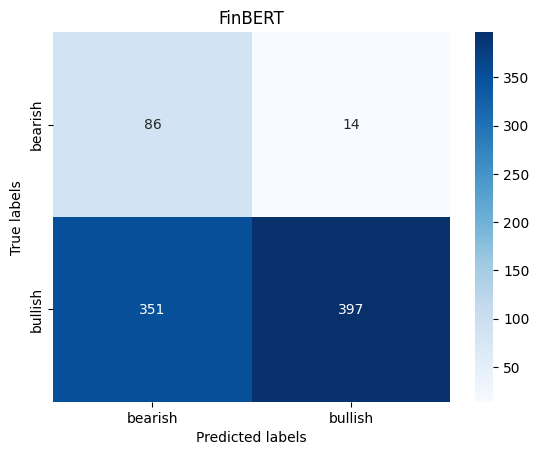

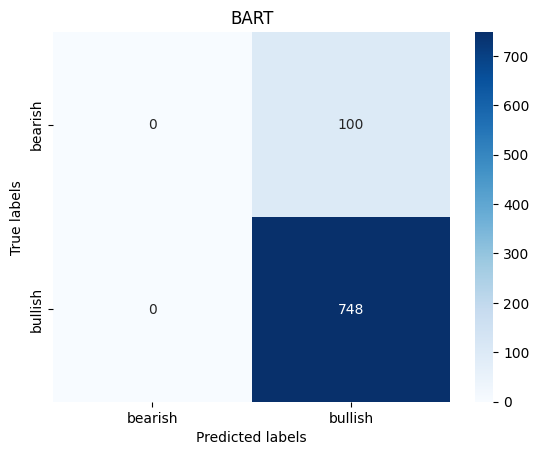

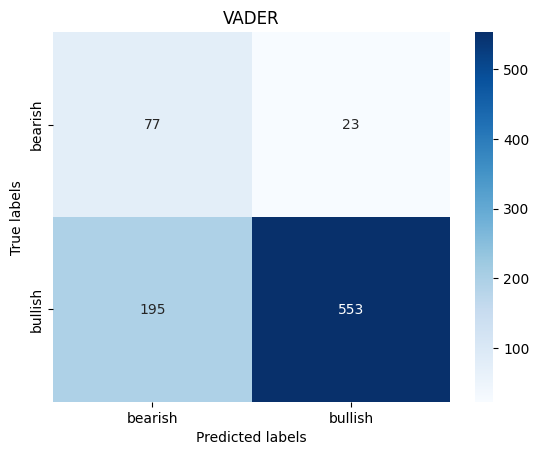

In [13]:
# plot confusion matrix for each model with respective plot title
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(['bearish', 'bullish'])
    ax.yaxis.set_ticklabels(['bearish', 'bullish'])
    plt.show()

plot_confusion_matrix(benchmark["sentiment"], benchmark["finbert"], "FinBERT")
plot_confusion_matrix(benchmark["sentiment"], benchmark["bart"], "BART")
plot_confusion_matrix(benchmark["sentiment"], benchmark["vader"], "VADER")


### Regression Metrics

In [95]:
from sklearn.metrics import mean_squared_error

benchmark["finbert_score"] = benchmark["finbert_positive"] - benchmark["finbert_negative"]
benchmark["bart_score"] = benchmark["bullish"] - benchmark["bearish"]
benchmark["vader_score"] = benchmark["compound"]

def get_mse(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    return pd.DataFrame({"model": model_name, "mse": mse}, index=[0])

finbert_mse = get_mse(benchmark["sentiment"], benchmark["finbert_score"], "FinBERT")
bart_mse = get_mse(benchmark["sentiment"], benchmark["bart_score"], "BART")
vader_mse = get_mse(benchmark["sentiment"], benchmark["vader_score"], "VADER")

all_mse = pd.concat([finbert_mse, bart_mse, vader_mse])
all_mse.set_index("model")

,mse
model,
FinBERT,1.187758
BART,0.537884
VADER,0.930165


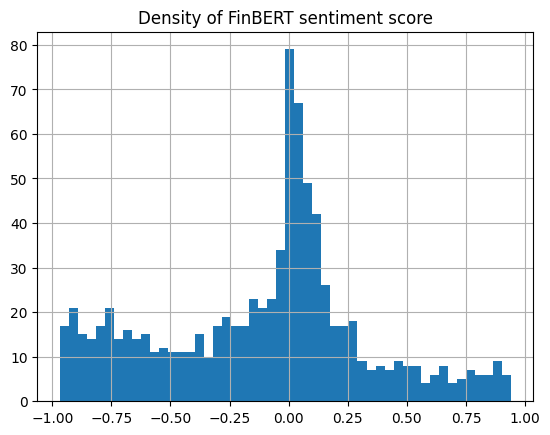

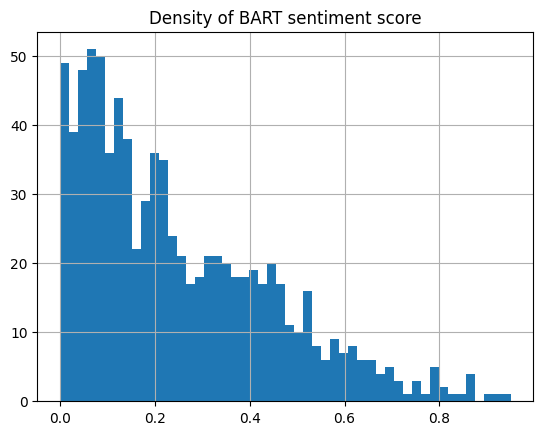

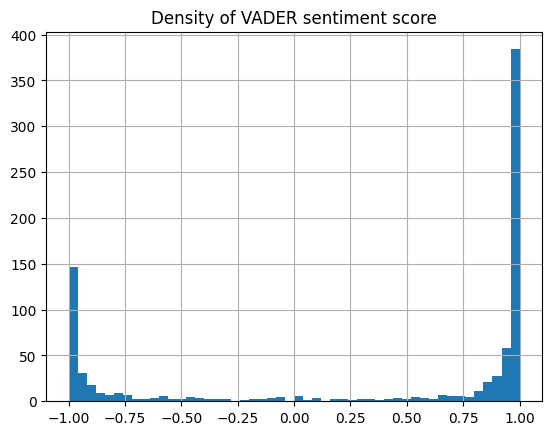

In [96]:
import matplotlib.pyplot as plt
# plot density of finbert_score
benchmark['finbert_score'].hist(bins=50)
# add title
plt.title('Density of FinBERT sentiment score')
plt.show()

benchmark["bart_score"].hist(bins=50)
plt.title('Density of BART sentiment score')
plt.show()

benchmark["vader_score"].hist(bins=50)
plt.title('Density of VADER sentiment score')
plt.show()

# Twitter Financial News Sentiment

In [19]:
from datasets import load_dataset
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment", split="train")
benchmark = dataset.to_pandas()
benchmark['label'] = benchmark['label'].apply(lambda x: -1 if x==0 else (0 if x==2 else 1))
benchmark.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,-1
1,$CCL $RCL - Nomura points to bookings weakness...,-1
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",-1
3,$ESS: BTIG Research cuts to Neutral https://t....,-1
4,$FNKO - Funko slides after Piper Jaffray PT cu...,-1


## FinBERT

In [33]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from functools import partial

# trim text to only first 3 sentences
def trim_text_to_sentences(text, max_sentences=5):
    sentences = text.split('.')
    trimmed_sentences = sentences[:max_sentences]
    trimmed_text = '.'.join(trimmed_sentences)
    return trimmed_text

def trim_text_to_tokens(text, max_tokens=180):
    tokens = word_tokenize(text)
    trimmed_tokens = tokens[:max_tokens]
    trimmed_text = ' '.join(trimmed_tokens)
    return trimmed_text

benchmark["text_trim"] = benchmark["text"].apply(trim_text_to_sentences)

finbert = FinBERT(device=-1, return_one_label=False)
predictions = finbert.pipeline_predict_sentiment(list(benchmark['text_trim']))
benchmark = FinBERT.add_predictions_to_df(benchmark, predictions)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Predicting...


100%|██████████| 9543/9543 [21:11<00:00,  7.50it/s]


## BART

In [22]:
## BartLargeMNLI
bart_large_mnli = BartLargeMNLI()
bart_large_mnli.initialize_model(device=0)

classes= ["bullish", "bearish"]
predictions = bart_large_mnli.predict_classes(list(benchmark['text']), classes, multi_label=False)
benchmark = BartLargeMNLI.add_predictions_to_df(benchmark, predictions, classes)

  0%|          | 10/9543 [00:02<23:26,  6.78it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 9543/9543 [09:57<00:00, 15.97it/s]


In [34]:
benchmark.to_csv("tfns_all.csv")

## VADER

In [23]:
# VADER
vader = Vader()
predictions = vader.pipeline_predict_sentiment(list(benchmark['text']))
benchmark = Vader.add_predictions_to_df(benchmark, predictions)

Predicting...


100%|██████████| 9543/9543 [00:01<00:00, 8186.84it/s]


## Results

In [45]:
benchmark.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'text', 'label', 'text_trim', '0',
       'sequence', 'bullish', 'bearish', 'neg', 'neu', 'pos', 'compound',
       'finbert_positive', 'finbert_negative', 'finbert_neutral'],
      dtype='object')

In [90]:
benchmark = pd.read_csv("tfns_all.csv")

def finbert_sentiment(row):
    if row["finbert_positive"] > row["finbert_negative"] and row["finbert_positive"] > row["finbert_neutral"]:
        return 1
    elif row["finbert_negative"] > row["finbert_positive"] and row["finbert_negative"] > row["finbert_neutral"]:
        return -1
    else:
        return 0

def bart_sentiment(row):
    if row["bullish"] > 2*row["bearish"]:
        return 1
    elif row["bearish"] > 2*row["bullish"]:
        return -1
    else:
        return 0

def vader_sentiment(row):
    if row["pos"] > row["neg"] and row["pos"] > row["neu"]:
        return 1
    elif row["neg"] > row["pos"] and row["neg"] > row["neu"]:
        return -1
    else:
        return 0

benchmark["vader"] = benchmark.apply(vader_sentiment, axis=1)
benchmark["bart"] = benchmark.apply(bart_sentiment, axis=1)
benchmark["finbert"] = benchmark.apply(finbert_sentiment, axis=1)

### Metrics

In [63]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred)
    }
    return metrics

def get_balanced_metrics(y_true, y_pred):
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    balanced_metrics = {
        "balanced_precision": metrics[0],
        "balanced_recall": metrics[1],
        "balanced_f1": metrics[2]
    }
    return balanced_metrics

def get_metrics_df(y_true, y_pred, model_name):
    metrics = get_metrics(y_true, y_pred)
    metrics["model"] = model_name
    metrics = metrics | get_balanced_metrics(y_true, y_pred)
    return pd.DataFrame(metrics, index=[0])

finbert_metrics = get_metrics_df(benchmark["label"], benchmark["finbert"], "FinBERT")
bart_metrics = get_metrics_df(benchmark["label"], benchmark["bart"], "BART")
vader_metrics = get_metrics_df(benchmark["label"], benchmark["vader"], "VADER")

all_metrics = pd.concat([finbert_metrics, bart_metrics, vader_metrics])
all_metrics.set_index("model")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,f1,balanced_accuracy,balanced_precision,balanced_recall,balanced_f1
model,,,,,,,,
FinBERT,0.712250,0.743080,0.712250,0.720250,0.702849,0.743080,0.712250,0.720250
BART,0.394635,0.628158,0.394635,0.384028,0.415342,0.628158,0.394635,0.384028
VADER,0.646233,0.563904,0.646233,0.516158,0.338444,0.563904,0.646233,0.516158


### Confusion Matrix

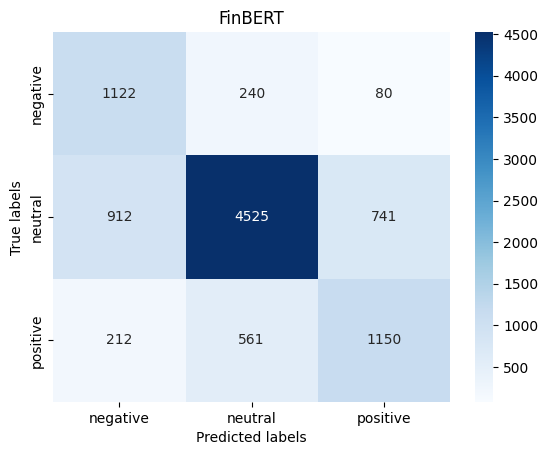

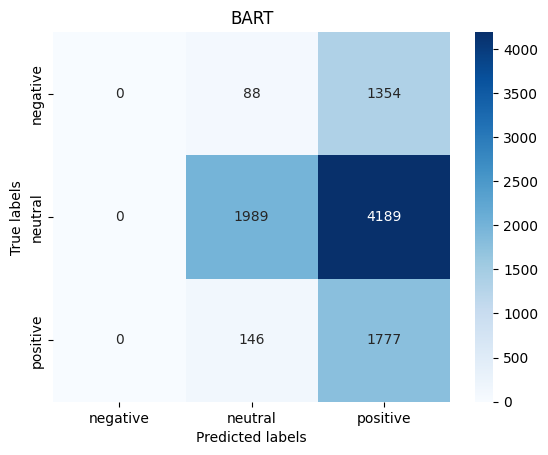

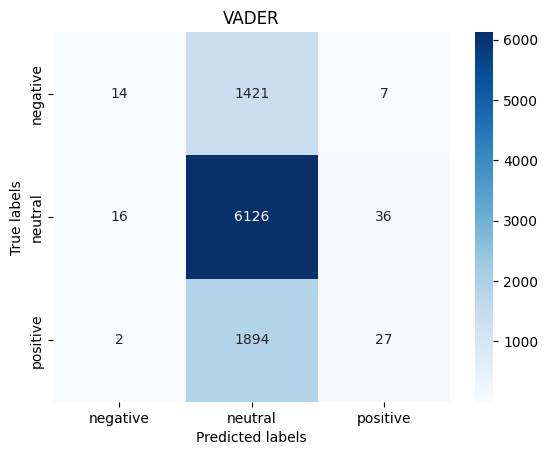

In [66]:
# plot confusion matrix for each model with respective plot title
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
    ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
    plt.show()

plot_confusion_matrix(benchmark["label"], benchmark["finbert"], "FinBERT")
plot_confusion_matrix(benchmark["label"], benchmark["bart"], "BART")
plot_confusion_matrix(benchmark["label"], benchmark["vader"], "VADER")


### Regression

In [92]:
from sklearn.metrics import mean_squared_error

benchmark["finbert_score"] = benchmark["finbert_positive"] - benchmark["finbert_negative"]
benchmark["bart_score"] = benchmark["bullish"] - benchmark["bearish"]
benchmark["vader_score"] = benchmark["compound"]

def get_mse(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    return pd.DataFrame({"model": model_name, "mse": mse}, index=[0])

finbert_mse = get_mse(benchmark["label"], benchmark["finbert_score"], "FinBERT")
bart_mse = get_mse(benchmark["label"], benchmark["bart_score"], "BART")
vader_mse = get_mse(benchmark["label"], benchmark["vader_score"], "VADER")

all_mse = pd.concat([finbert_mse, bart_mse, vader_mse])
all_mse.set_index("model")

,mse
model,
FinBERT,0.271384
BART,0.751449
VADER,0.360806


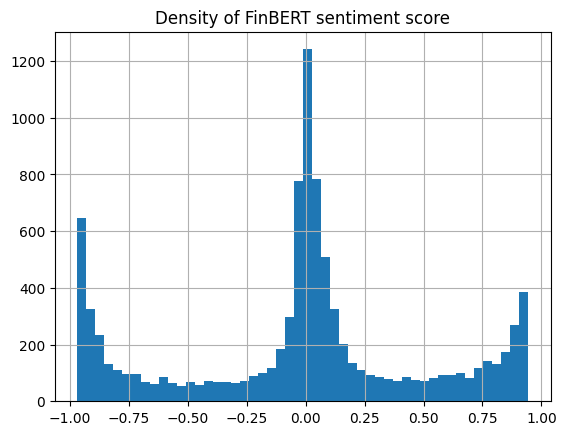

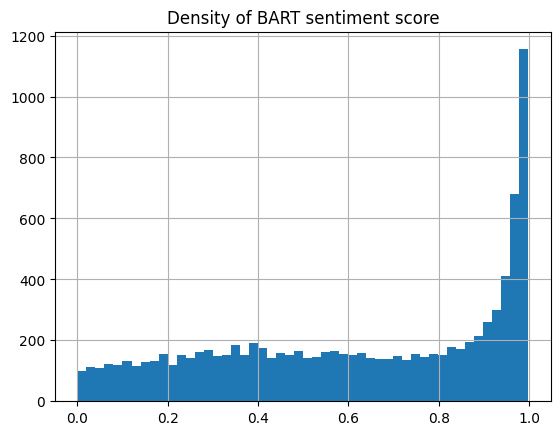

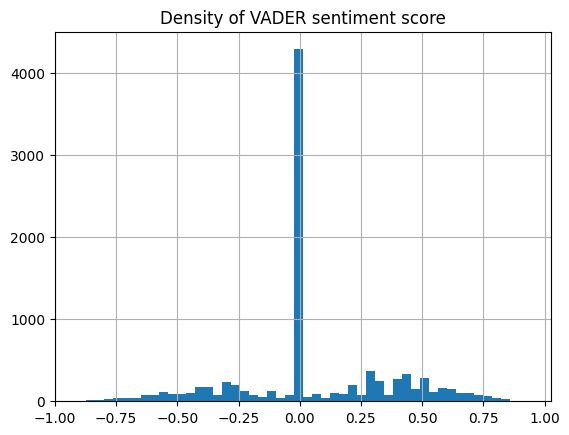

In [93]:
import matplotlib.pyplot as plt
# plot density of finbert_score
benchmark['finbert_score'].hist(bins=50)
# add title
plt.title('Density of FinBERT sentiment score')
plt.show()

benchmark["bart_score"].hist(bins=50)
plt.title('Density of BART sentiment score')
plt.show()

benchmark["vader_score"].hist(bins=50)
plt.title('Density of VADER sentiment score')
plt.show()

# Financial Phrasebank

In [72]:
from datasets import load_dataset
dataset = load_dataset("financial_phrasebank", "sentences_allagree")
benchmark = dataset["train"].to_pandas()
benchmark['label'] = benchmark['label'].apply(lambda x: x-1)
benchmark.head()

,sentence,label
0,"According to Gran , the company has no plans t...",0
1,"For the last quarter of 2010 , Componenta 's n...",1
2,"In the third quarter of 2010 , net sales incre...",1
3,Operating profit rose to EUR 13.1 mn from EUR ...,1
4,"Operating profit totalled EUR 21.1 mn , up fro...",1


In [82]:
benchmark["label"].value_counts()

 0    1391
 1     570
-1     303
Name: label, dtype: int64

## FinBERT

In [74]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from functools import partial

benchmark["text_trim"] = benchmark["sentence"].apply(trim_text_to_sentences)

finbert = FinBERT(device=-1, return_one_label=False)
predictions = finbert.pipeline_predict_sentiment(list(benchmark['text_trim']))
benchmark = FinBERT.add_predictions_to_df(benchmark, predictions)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Predicting...


100%|██████████| 2264/2264 [05:58<00:00,  6.31it/s]


## BART

In [75]:
## BartLargeMNLI
bart_large_mnli = BartLargeMNLI()
bart_large_mnli.initialize_model(device=0)

classes= ["bullish", "bearish"]
predictions = bart_large_mnli.predict_classes(list(benchmark['sentence']), classes, multi_label=False)
benchmark = BartLargeMNLI.add_predictions_to_df(benchmark, predictions, classes)

  0%|          | 10/2264 [00:00<02:17, 16.41it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2264/2264 [03:04<00:00, 12.24it/s]


## VADER

In [76]:
# VADER
vader = Vader()
predictions = vader.pipeline_predict_sentiment(list(benchmark['sentence']))
benchmark = Vader.add_predictions_to_df(benchmark, predictions)

Predicting...


100%|██████████| 2264/2264 [00:00<00:00, 9879.13it/s] 


In [77]:
benchmark.to_csv("finphrbank_all.csv")

In [78]:
benchmark = pd.read_csv("finphrbank_all.csv")

def finbert_sentiment(row):
    if row["finbert_positive"] > row["finbert_negative"] and row["finbert_positive"] > row["finbert_neutral"]:
        return 1
    elif row["finbert_negative"] > row["finbert_positive"] and row["finbert_negative"] > row["finbert_neutral"]:
        return -1
    else:
        return 0

def bart_sentiment(row):
    if row["bullish"] > 2*row["bearish"]:
        return 1
    elif row["bearish"] > 2*row["bullish"]:
        return -1
    else:
        return 0

def vader_sentiment(row):
    if row["pos"] > row["neg"] and row["pos"] > row["neu"]:
        return 1
    elif row["neg"] > row["pos"] and row["neg"] > row["neu"]:
        return -1
    else:
        return 0

benchmark["vader"] = benchmark.apply(vader_sentiment, axis=1)
benchmark["bart"] = benchmark.apply(bart_sentiment, axis=1)
benchmark["finbert"] = benchmark.apply(finbert_sentiment, axis=1)

In [79]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred)
    }
    return metrics

def get_balanced_metrics(y_true, y_pred):
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    balanced_metrics = {
        "balanced_precision": metrics[0],
        "balanced_recall": metrics[1],
        "balanced_f1": metrics[2]
    }
    return balanced_metrics

def get_metrics_df(y_true, y_pred, model_name):
    metrics = get_metrics(y_true, y_pred)
    metrics["model"] = model_name
    metrics = metrics | get_balanced_metrics(y_true, y_pred)
    return pd.DataFrame(metrics, index=[0])

finbert_metrics = get_metrics_df(benchmark["label"], benchmark["finbert"], "FinBERT")
bart_metrics = get_metrics_df(benchmark["label"], benchmark["bart"], "BART")
vader_metrics = get_metrics_df(benchmark["label"], benchmark["vader"], "VADER")

all_metrics = pd.concat([finbert_metrics, bart_metrics, vader_metrics])
all_metrics.set_index("model")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefined

,accuracy,precision,recall,f1,balanced_accuracy,balanced_precision,balanced_recall,balanced_f1
model,,,,,,,,
FinBERT,0.971731,0.973204,0.971731,0.972039,0.975874,0.973204,0.971731,0.972039
BART,0.614399,0.661438,0.614399,0.599172,0.504878,0.661438,0.614399,0.599172
VADER,0.613958,0.377382,0.613958,0.467441,0.333094,0.377382,0.613958,0.467441


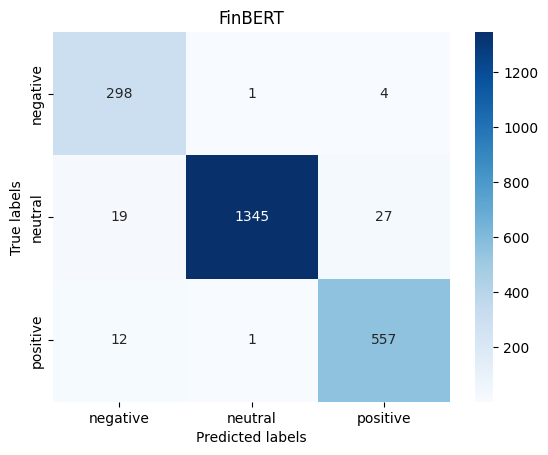

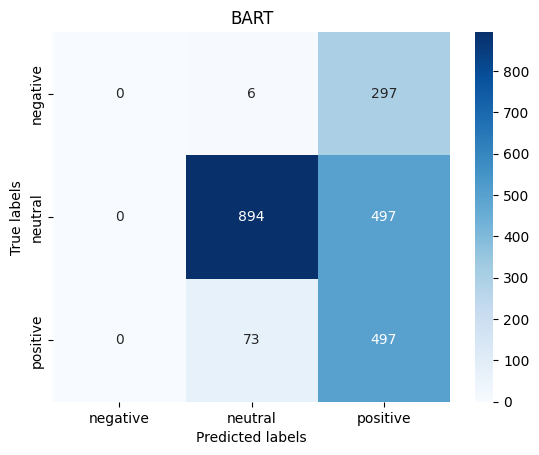

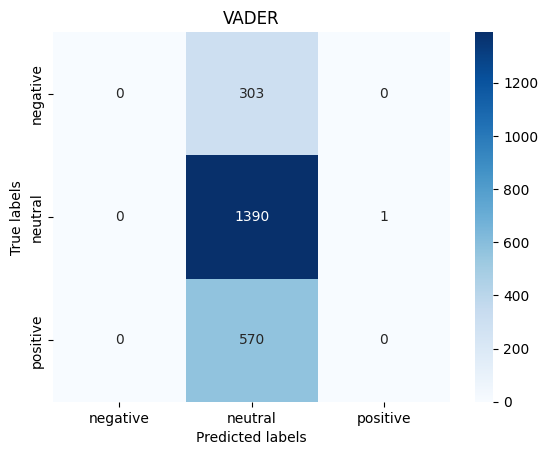

In [80]:
# plot confusion matrix for each model with respective plot title
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
    ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
    plt.show()

plot_confusion_matrix(benchmark["label"], benchmark["finbert"], "FinBERT")
plot_confusion_matrix(benchmark["label"], benchmark["bart"], "BART")
plot_confusion_matrix(benchmark["label"], benchmark["vader"], "VADER")


In [81]:
from sklearn.metrics import mean_squared_error

benchmark["finbert_score"] = benchmark["finbert_positive"] - benchmark["finbert_negative"]
benchmark["bart_score"] = benchmark["bullish"] - benchmark["bearish"]
benchmark["vader_score"] = benchmark["compound"]

def get_mse(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    return pd.DataFrame({"model": model_name, "mse": mse}, index=[0])

finbert_mse = get_mse(benchmark["label"], benchmark["finbert_score"], "FinBERT")
bart_mse = get_mse(benchmark["label"], benchmark["bart_score"], "BART")
vader_mse = get_mse(benchmark["label"], benchmark["vader_score"], "VADER")

all_mse = pd.concat([finbert_mse, bart_mse, vader_mse])
all_mse.set_index("model")

,mse
model,
FinBERT,0.040803
BART,0.576730
VADER,0.359769


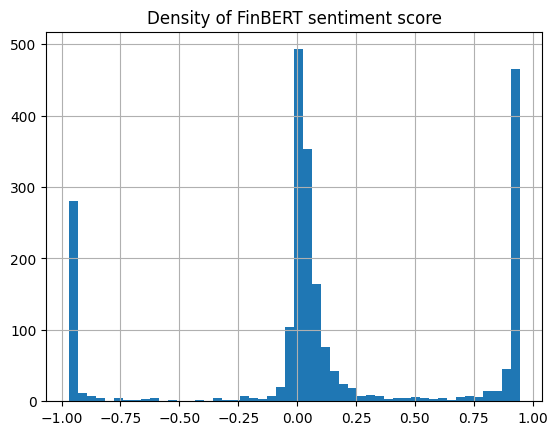

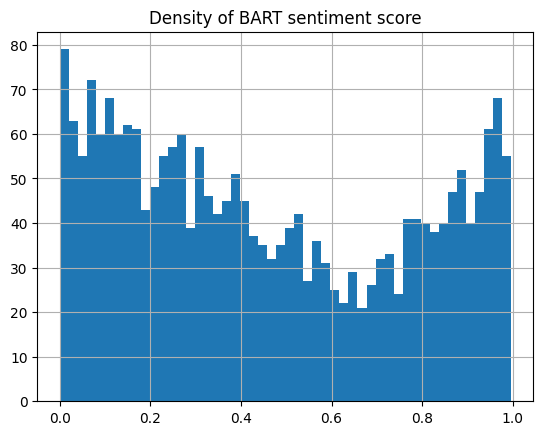

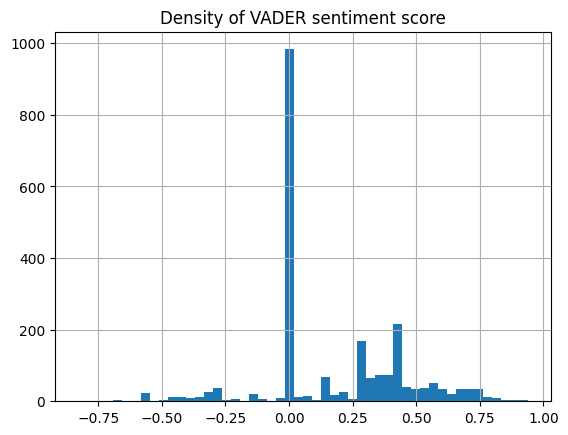

In [89]:
import matplotlib.pyplot as plt
# plot density of finbert_score
benchmark['finbert_score'].hist(bins=50)
# add title
plt.title('Density of FinBERT sentiment score')
plt.show()

benchmark["bart_score"].hist(bins=50)
plt.title('Density of BART sentiment score')
plt.show()

benchmark["vader_score"].hist(bins=50)
plt.title('Density of VADER sentiment score')
plt.show()